## Part5: Fully-Connected Neural Nets (65 points)
<font size='4'>In this part we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass.

<font size='4'>After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

<font size='4'>In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization. 

### Setup

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
# from utils.classifiers.fc_net import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


<font size='4' color='red'>**Task 5.1: Affine layer: foward pass (no for loops are allowed) (4 points).**

In [57]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    row = x.shape[0]
    col = np.prod(x.shape[1:]) 
    x_reshape = x.reshape(row, col)
    out = np.dot(x_reshape, w) + b
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

In [58]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.7698500479884e-10


<font size='4' color='red'>**Task 5.2: Affine layer: backward pass (no for loops are allowed) (4 points).**
    
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [60]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    
    x = cache[0]
    w = cache[1]
    b = cache[2]

    row = x.shape[0]
    col = np.prod(x.shape[1:])
    x_reshape = x.reshape(row, col)

    dw = x_reshape.T.dot(dout)
    dx = dout.dot(w.T).reshape(x.shape)
    db = np.sum(dout, axis=0)
                
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [61]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


<font size='4' color='red'>**Task 5.3: ReLU activation: forward pass (no for loops are allowed) (3 points).**
    
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [63]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    
    out = np.maximum(0, x)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

In [64]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


<font size='4' color='red'>**Task 5.4: ReLU activation: backward pass (no for loops are allowed) (3 points).**
    
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [65]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    
    x = cache
    out = np.maximum(0, x)
    out[out > 0 ] = 1
    dx = out * dout

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [66]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


<font size='4' color='red'>**Inline Question 5.5 (2 points):** 

<font size='4' color='red'>We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behavior?
<font size='4' color='red'>1. Sigmoid
    
<font size='4' color='red'>2. ReLU
    
<font size='4' color='red'>3. Leaky ReLU

### Answer:
[Sigmoid and Tanh are examples of activation functions that have a problem of zero gradient flow or vanishing gradient problem. They are generally not preferred when the number of layers in the neural netwrok is large. In sigmoid, large input space is squished into a small input space between 0 and 1 so a large change in input to this function causes small change in putput and derivative becomes small.]


<font size='4' color='red'>**Task 5.6: "Sandwich" layers (no for loops are allowed) (7 points where 3 for the forward and 4 for the backward).**
    
<font size='4'>There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. 

<font size='4'>Implement the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass.
    
<font size='4'>You need to re-use the functions you have implemented earlier. You need to decide how to use the cached results given by `affine_forward` and `relu_forward`.

In [67]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    
    ###########################################################################
    # TODO: Implement the Affine-ReLU forward pass.                           #
    ###########################################################################
    
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    
    Input:
    - dout: Upstream derivatives, of any shape
    - cache: cached results from the affine_relu_forward pass

    Returns:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    
    """
    ###########################################################################
    # TODO: Implement the Affine-ReLU backward pass.                          #
    ###########################################################################
    
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx, dw, db

In [68]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.395535042049294e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


<font size='4' color='red'>**Task 5.7: Softmax loss layer (no for loops are allowed) (6 points).**

In [71]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    ###########################################################################
    # TODO: Implement the softmax_loss function,                              #
    # including the forward and backward passes.                              #
    ###########################################################################
    
    prob = np.exp(x - np.max(x, axis=1, keepdims=True))
    prob = prob/np.sum(prob, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(prob[np.arange(N), y])) / N
    dx = prob.copy()
    dx[np.arange(N), y] -= 1
    dx = dx/N

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return loss, dx

In [72]:
# Let's check your implementation
np.random.seed(5330)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302800487936905
dx error:  9.169036489219965e-09


<font size='4' color='red'>**Task 5.8: Two-layer network (no for loops are allowed in your implementation) (9 points)**
    
<font size='4'>Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [73]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        
        self.params['W1'] = np.random.normal(scale=weight_scale, size=(input_dim, hidden_dim))
        self.params['W2'] = np.random.normal(scale=weight_scale, size=(hidden_dim, num_classes))
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['b2'] = np.zeros(num_classes)
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        
        out_1, cache_1 = affine_relu_forward(X, self.params['W1'], self.params['b1'])
        out_2, cache_2 = affine_forward(out_1, self.params['W2'], self.params['b2'])
        scores = out_2

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        #data loss
        loss, dscores = softmax_loss(scores, y)
        #loss = data loss + regularization
        loss += 0.5*self.reg*np.sum(self.params['W1']**2) + 0.5*self.reg*np.sum(self.params['W2']**2)

        dx_2, grads['W2'], grads['b2'] = affine_backward(dscores, cache_2)
        dx_1, grads['W1'], grads['b1'] = affine_relu_backward(dx_2, cache_1)
 
        grads['W2'] += self.reg*self.params['W2']
        grads['W1'] += self.reg*self.params['W1']
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [74]:
# Let's check your implementation
np.random.seed(5330)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.34e-10
b1 relative error: 4.73e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


<font size='4' color='red'>**Task 5.9: Solver (4 points).**
    
<font size='4'>Following a more modular design, we have split the logic for training models into a separate class.

<font size='4'>Open the file `pa4_code/utils/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that <font color='red'>achieves at least `50%` accuracy on the validation set.

In [75]:
from utils.solver import Solver

model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data, optim_config={"learning_rate":0.001}, print_every=500)
solver.train()
solver.best_val_acc
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.303352
(Epoch 0 / 10) train acc: 0.155000; val_acc: 0.138000
(Epoch 1 / 10) train acc: 0.440000; val_acc: 0.428000
(Iteration 501 / 4900) loss: 1.618684
(Epoch 2 / 10) train acc: 0.496000; val_acc: 0.449000
(Iteration 1001 / 4900) loss: 1.285687
(Epoch 3 / 10) train acc: 0.502000; val_acc: 0.459000
(Iteration 1501 / 4900) loss: 1.345270
(Epoch 4 / 10) train acc: 0.553000; val_acc: 0.482000
(Iteration 2001 / 4900) loss: 1.378024
(Epoch 5 / 10) train acc: 0.539000; val_acc: 0.482000
(Iteration 2501 / 4900) loss: 1.065101
(Epoch 6 / 10) train acc: 0.530000; val_acc: 0.487000
(Iteration 3001 / 4900) loss: 1.118573
(Epoch 7 / 10) train acc: 0.562000; val_acc: 0.490000
(Iteration 3501 / 4900) loss: 1.112108
(Epoch 8 / 10) train acc: 0.581000; val_acc: 0.508000
(Iteration 4001 / 4900) loss: 1.271148
(Epoch 9 / 10) train acc: 0.570000; val_acc: 0.479000
(Iteration 4501 / 4900) loss: 1.373379
(Epoch 10 / 10) train acc: 0.571000; val_acc: 0.496000


0.508

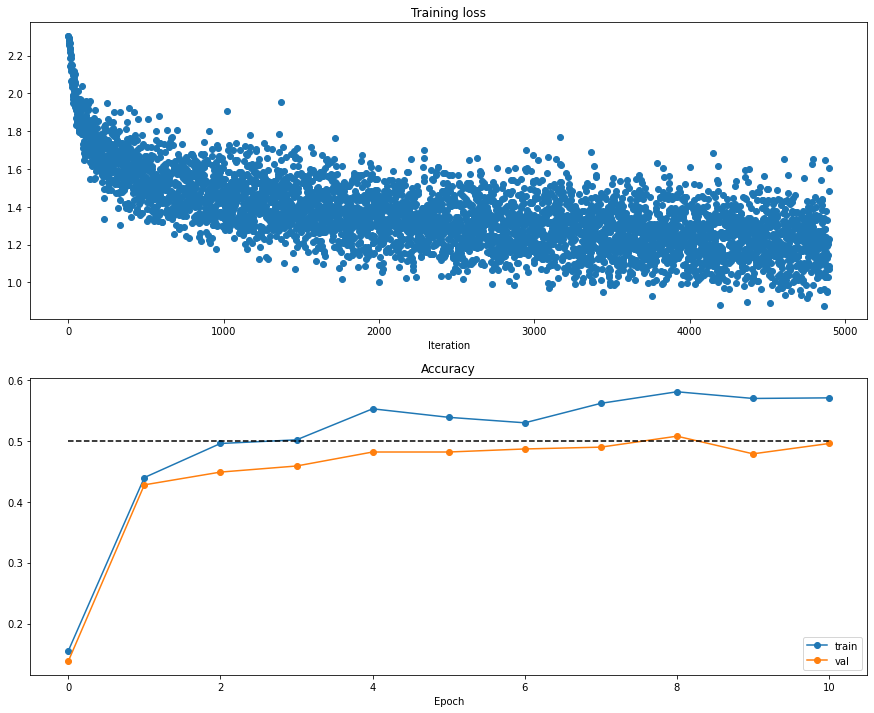

In [76]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

<font size='4' color='red'>**Task 5.10: Multilayer network (10 points).**
    
<font size='4'>Next you will implement a fully-connected network with an arbitrary number of hidden layers.

<font size='4'>Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization.

In [79]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. For a network with L layers,
    the architecture will be

    {affine - relu} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        layer_input_dim = input_dim
        for i,hd in enumerate(hidden_dims):
            self.params['W%d'%(i+1)] = weight_scale * np.random.randn(layer_input_dim,hd)
            self.params['b%d'%(i+1)] = weight_scale * np.zeros(hd)
            layer_input_dim = hd
         #final output layer
        self.params['W%d'%(self.num_layers)] = weight_scale * np.random.randn(layer_input_dim,num_classes)
        self.params['b%d'%(self.num_layers)] = weight_scale * np.zeros(num_classes)  

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################


        layer_input = X
        ar_cache = {} # Affine ReLU Cache
        for lay in range(self.num_layers-1):
            layer_input, ar_cache[lay] = affine_relu_forward(layer_input,self.params['W%d'%(lay+1)],self.params['b%d'%(lay+1)])
         #The Last layer 
        ar_out,ar_cache[self.num_layers] = affine_forward(layer_input,self.params['W%d'%(self.num_layers)],self.params['b%d'%(self.num_layers)])
        scores = ar_out
            
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        loss, dscores = softmax_loss(scores, y)
        dhout = dscores
        loss = loss + 0.5 * self.reg * np.sum(self.params['W%d'%(self.num_layers)] * self.params['W%d'%(self.num_layers)])
        # From the last layer to the input layer
        dx,dw,db = affine_backward(dhout,ar_cache[self.num_layers])
        grads['W%d'%(self.num_layers)] = dw + self.reg * self.params['W%d'%(self.num_layers)]
        grads['b%d'%(self.num_layers)] = db
        dhout = dx #upstream gradient

        for idx in range(self.num_layers - 1):
            lay = self.num_layers - 1 - idx - 1
            loss = loss + 0.5 *  self.reg * np.sum(self.params['W%d'%(lay+1)] * self.params['W%d'%(lay+1)])
            dx, dw, db = affine_relu_backward(dhout,ar_cache[lay])
            grads['W%d'%(lay+1)] = dw + self.reg * self.params['W%d'%(lay+1)]
            grads['b%d'%(lay+1)] = db
            dhout = dx
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


In [80]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D, 
        num_classes=C,
        reg=reg, 
        weight_scale=5e-2, 
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
    # Most of the errors should be on the order of 1e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of 1e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.03e-07
W2 relative error: 2.21e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.69e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.41e-08
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 2.38e-10


<font size='4' color='red'>**Task 5.11: Overfitting a small dataset (2 points).**

<font size='4'>As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 3.604568
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.121000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.130000
(Epoch 2 / 20) train acc: 0.640000; val_acc: 0.173000
(Epoch 3 / 20) train acc: 0.780000; val_acc: 0.199000
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.190000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.194000
(Iteration 11 / 40) loss: 0.189322
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.187000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.186000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.183000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.175000
(Iteration 21 / 40) loss: 0.081366
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.179000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.176000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.170000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.174000
(Iteration 31 / 40) loss: 

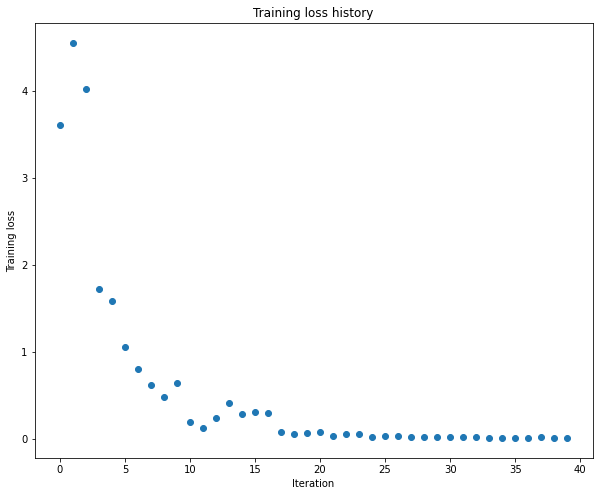

In [81]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

weight_scale = 2e-2
learning_rate = 1e-2

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale, 
    dtype=np.float64

)
solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Task 5.12: Overfitting a small dataset with a five-layer network (2 points).**
    
<font size='4'>Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.839886
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.106000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.087000
(Epoch 2 / 20) train acc: 0.420000; val_acc: 0.124000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.140000
(Epoch 4 / 20) train acc: 0.720000; val_acc: 0.151000
(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.172000
(Iteration 11 / 40) loss: 0.979193
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.173000
(Epoch 7 / 20) train acc: 0.860000; val_acc: 0.170000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.160000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.165000
(Epoch 10 / 20) train acc: 0.900000; val_acc: 0.185000
(Iteration 21 / 40) loss: 0.378285
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.177000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.177000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.177000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.177000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.173000
(Iteration 31 / 40) loss: 

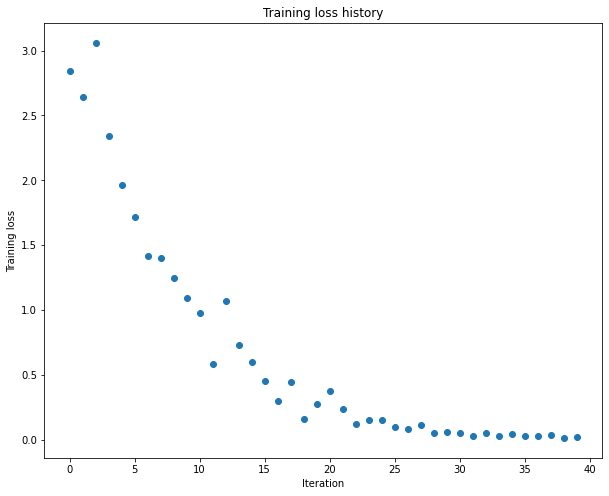

In [82]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################
weight_scale = 4e-2
learning_rate = 25e-3

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale, 
    dtype=np.float64
)

solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Inline Question 5.13 (2 points):** 
    
<font size='4' color='red'>**Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?**

<font size='4'>**Answer:**
    
[The 5 layer network is more sensitive than the 3 layer network. The 5 layer network is deeper than 3 layer, and the vanishing gradient is more prominent. So we need to increase the weight scale, and simultaneously learning rate must also be increased. ]


<font size='4' color='red'>**Task 5.14: SGD+Momentum (3 points)**
    
<font size='4'>Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

<font size='4'>Open the file `pa4_code/utils/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule below and run the following to check your implementation. You should see errors less than 1e-8.

In [83]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    ###########################################################################
    # TODO: Implement the momentum update formula. Store the updated value in #
    # the next_w variable. You should also use and update the velocity v.     #
    ###########################################################################
    
    v = config['momentum']*v - config['learning_rate']*dw
    next_w = w + v

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    config['velocity'] = v

    return next_w, config

In [84]:
# Let's check your implementation
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291086
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082693
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.022463
(Iteration 71 / 200) loss: 2.029975
(Epoch 2 / 5) train acc: 0.353000; val_acc: 0.312000
(Iteration 81 / 200) loss: 1.805454
(Iteration 91 / 200) loss: 1.911051
(Iteration 101 / 200) loss: 1.914574
(Iteration 111 / 200) loss: 1.706396
(Epoch 3 / 5) train acc: 0.409000; val_acc: 0.327000
(Iteration 121 / 200) loss: 1.706038
(Iteration 131 / 200) loss: 1.779879
(Iteration 141 / 200) loss: 1.798783
(Iteration 151 / 200) loss: 1.819628
(Epoch 4 / 5) train acc: 0.425000; val_acc: 0.324000
(Iteration 161 / 200) loss: 1.624850
(Iteration 171 / 200) loss: 1.888063
(Iteration 181 / 200) loss: 1.540264
(Iteration 191 / 200) los

/home/aadityasp/anaconda3/envs/cs5330_pa4/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/aadityasp/anaconda3/envs/cs5330_pa4/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/aadityasp/anaconda3/envs/cs5330_pa4/lib/python3.6/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the s

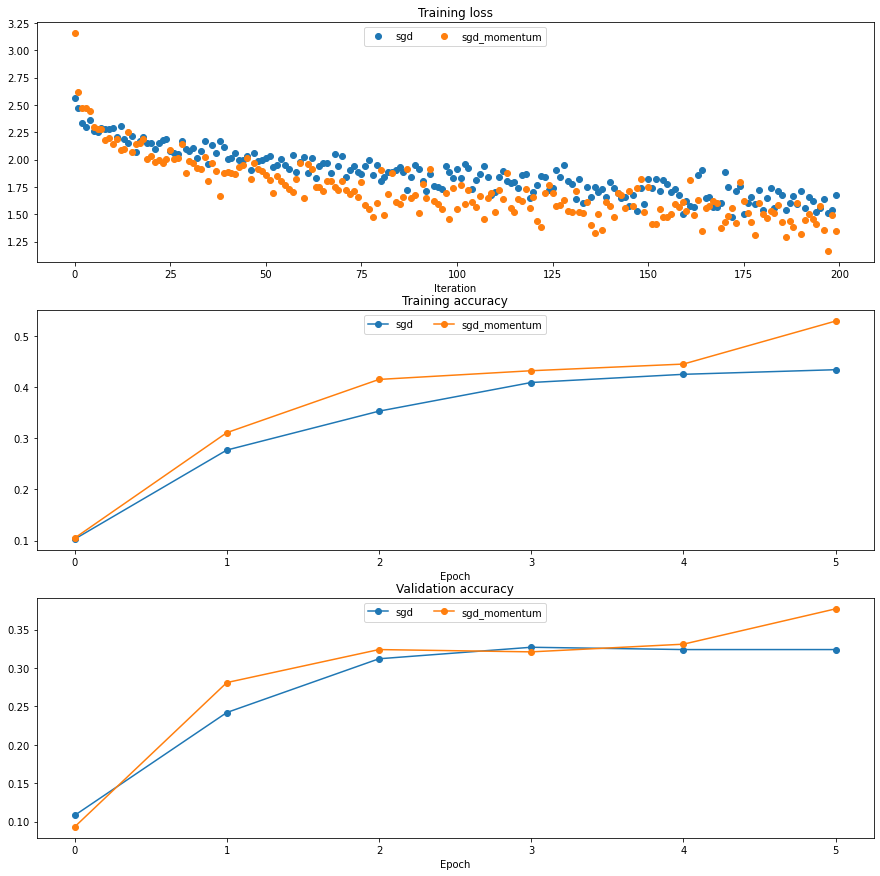

In [85]:
# Run the following to train a six-layer network with both SGD and SGD+momentum. 
# You should see the SGD+momentum update rule converge faster.
from utils.solver import Solver

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(
        model, small_data,
        num_epochs=5, batch_size=100,
        update_rule=update_rule if update_rule == 'sgd' else sgd_momentum,
        optim_config={'learning_rate': 1e-2,},
        verbose=True
    )

    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

<font size='4' color='red'>**Task 5.15: Train a good model! (4 points)**
    
<font size='4'>Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. <font color='red'>We require you to get at least 50% accuracy on the validation set using a fully-connected net within 50 epochs.

<font size='4'>If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. 

In [55]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################

model = FullyConnectedNet(
    [512, 256, 256],
    weight_scale=1e-2,
)
solver = Solver(
    model,
    data,
    num_epochs=50,
    print_every=100,
    batch_size=256,
    update_rule=sgd_momentum,
    optim_config={'learning_rate': 1e-3},
    verbose=True
)
solver.train()
best_model = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 9550) loss: 2.309809
(Epoch 0 / 50) train acc: 0.102000; val_acc: 0.109000
(Iteration 101 / 9550) loss: 1.883654
(Epoch 1 / 50) train acc: 0.392000; val_acc: 0.413000
(Iteration 201 / 9550) loss: 1.683954
(Iteration 301 / 9550) loss: 1.577727
(Epoch 2 / 50) train acc: 0.474000; val_acc: 0.435000
(Iteration 401 / 9550) loss: 1.501735
(Iteration 501 / 9550) loss: 1.402146
(Epoch 3 / 50) train acc: 0.511000; val_acc: 0.474000
(Iteration 601 / 9550) loss: 1.361247
(Iteration 701 / 9550) loss: 1.339100
(Epoch 4 / 50) train acc: 0.543000; val_acc: 0.503000
(Iteration 801 / 9550) loss: 1.299970
(Iteration 901 / 9550) loss: 1.214852
(Epoch 5 / 50) train acc: 0.559000; val_acc: 0.519000
(Iteration 1001 / 9550) loss: 1.116884
(Iteration 1101 / 9550) loss: 1.184738
(Epoch 6 / 50) train acc: 0.595000; val_acc: 0.501000
(Iteration 1201 / 9550) loss: 1.219030
(Iteration 1301 / 9550) loss: 1.076097
(Epoch 7 / 50) train acc: 0.611000; val_acc: 0.499000
(Iteration 1401 / 9550) loss: 0.96

In [56]:
# Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.555
Test set accuracy:  0.535


## Extra credit (10 points)

<font size='4'>If you'd like to work on the extra-credit tasks, implement them below. <font color='red'>Do not add them to the regular tasks.

<font size='4' color='red'>**1. Implement the Adam optimizer and test its performance compared with SGD and SGD+Momentum. (2 points)**

<font size='4' color='red'>**2. Currently, the `Solver` class only accepts a single scalar for the learning rate decay (`lr_decay`). Implement a `LearningRateScheduler` class that processes the learning rate decay. Implement the cosine learning rate decay scheduler. Test its performance. (8 points)**